In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
%matplotlib inline


In [2]:
url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
df = pd.read_csv(url)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26353 entries, 0 to 26352
Data columns (total 11 columns):
dateRep                    26353 non-null object
day                        26353 non-null int64
month                      26353 non-null int64
year                       26353 non-null int64
cases                      26353 non-null int64
deaths                     26353 non-null int64
countriesAndTerritories    26353 non-null object
geoId                      26247 non-null object
countryterritoryCode       26289 non-null object
popData2019                26289 non-null float64
continentExp               26353 non-null object
dtypes: float64(1), int64(5), object(5)
memory usage: 2.2+ MB


In [4]:
df.head(5)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp
0,28/06/2020,28,6,2020,165,20,Afghanistan,AF,AFG,38041757.0,Asia
1,27/06/2020,27,6,2020,276,8,Afghanistan,AF,AFG,38041757.0,Asia
2,26/06/2020,26,6,2020,460,36,Afghanistan,AF,AFG,38041757.0,Asia
3,25/06/2020,25,6,2020,234,21,Afghanistan,AF,AFG,38041757.0,Asia
4,24/06/2020,24,6,2020,338,20,Afghanistan,AF,AFG,38041757.0,Asia


In [5]:
#Convert data strin columns to Pandas datatime .
df["dateRep"] = pd.to_datetime(df["dateRep"], format='%d/%m/%Y')

In [6]:
df['countriesAndTerritories'].value_counts(sort=True)

United_Kingdom                                181
Belgium                                       181
Germany                                       181
Netherlands                                   181
United_States_of_America                      181
Sweden                                        181
Russia                                        181
Singapore                                     181
Norway                                        181
Switzerland                                   181
Iceland                                       181
Japan                                         181
Canada                                        181
Australia                                     181
Czechia                                       181
Denmark                                       181
China                                         181
Italy                                         181
France                                        181
Iran                                          181


In [7]:
df.isnull().sum()

dateRep                      0
day                          0
month                        0
year                         0
cases                        0
deaths                       0
countriesAndTerritories      0
geoId                      106
countryterritoryCode        64
popData2019                 64
continentExp                 0
dtype: int64

In [8]:
df[df['geoId'].isnull()]['countriesAndTerritories'].nunique()

1

In [9]:
#Concatenate the Values countriesAndTerritories	geoId	countryterritoryCode to ensure we have unique values
cols = ['countryterritoryCode', 'countriesAndTerritories', 'geoId']
df['location'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [10]:
df['location'].nunique()

210

We notice that the fields geoId, CountryTerritoryCode, CountriesAndTerritories have a 1:1 relation and we can get rid of these redundant features. Keeping countriesAndTerritories as it is has non-null values and getting rid of other two features.


In [11]:
df.drop(['geoId','countryterritoryCode'], axis = 1, inplace=True)

In [12]:
df['continentExp'].value_counts()

Europe     7954
Asia       6248
Africa     5686
America    5453
Oceania     948
Other        64
Name: continentExp, dtype: int64

In [13]:
df[['cases','deaths','popData2019']].describe()

,cases,deaths,popData2019
count,26353.000000,26353.000000,2.628900e+04
mean,377.661253,18.916973,4.697303e+07
std,2155.418932,121.757959,1.677347e+08
min,-2461.000000,-1918.000000,8.150000e+02
25%,0.000000,0.000000,1.919968e+06
50%,4.000000,0.000000,8.858775e+06
75%,67.000000,1.000000,3.194979e+07
max,54771.000000,4928.000000,1.433784e+09


In [14]:
 df.groupby(by='continentExp')[['cases','deaths','popData2019']].agg(['max','min','mean','std']).sort_values([('deaths', 'max')], ascending=False)

cases                                deaths                   \
                max   min        mean          std    max   min       mean   
continentExp                                                                 
America       54771 -2461  925.471850  4323.584933   4928     0  44.889602   
Europe        11656  -766  301.442670  1088.024821   2004 -1918  23.988811   
Asia          19906     0  340.410211  1143.221144   2003     0   8.532170   
Africa         7210  -209   65.326767   309.986632    168     0   1.667253   
Oceania         611     0    9.712025    46.225155      7     0   0.140295   
Other           134    -9   10.875000    27.530358      2     0   0.109375   

                           popData2019                                        
                     std           max       min          mean           std  
continentExp                                                                  
America       227.102786  3.290649e+08    3372.0  2.973251e+07  7.016723e+07  
Europe        107.000352  1.458723e+08     815.0  1.616628e+07  2.837950e+07  
Asia           42.886629  1.433784e+09  433296.0  1.245088e+08  3.217868e+08  
Africa          7.589587  2.009636e+08   97741.0  2.810303e+07  4.008897e+07  
Oceania         0.603003  2.520320e+07   57213.0  6.783691e+06  9.366525e+06  
Other           0.403051           NaN       NaN           NaN           NaN

**Add a new feature to understand the death rate per million and cases reported per million. Before this ensure there are no null values for population**




In [15]:
df[df['popData2019'].isnull()]['countriesAndTerritories'].unique()

array(['Cases_on_an_international_conveyance_Japan'], dtype=object)

In [16]:
IntJapan = df[df['popData2019'].isnull()]
IntJapan[IntJapan['cases'] == IntJapan['cases'].max()]

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,popData2019,continentExp,location
4698,2020-02-16,16,2,2020,134,0,Cases_on_an_international_conveyance_Japan,NaN,Other,nan_Cases_on_an_international_conveyance_Japan...


In [17]:
#Drop the columns which do not have population density - This data belongs to a particular category and can be reiterated later
df = df[df['popData2019'].notna()]

In [18]:
df['casesPerX'] = df['cases']/df['popData2019']
df['deathsPerX'] = df['deaths']/df['popData2019']

**EDA - Visualization**



In [19]:
plt.style.use('seaborn-colorblind')

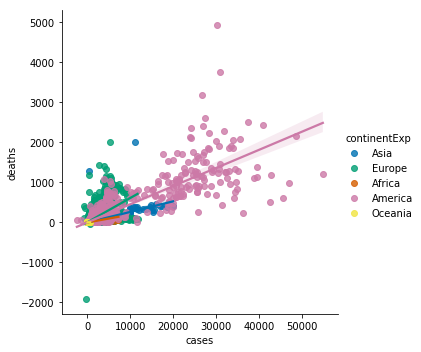

In [20]:
sns.lmplot(x='cases', y="deaths",hue="continentExp", data=df,fit_reg=True);


In [21]:
cols = ['month','cases','deaths','casesPerX','deathsPerX','popData2019']
df[cols].corr()[cols]

,month,cases,deaths,casesPerX,deathsPerX,popData2019
month,1.000000,0.090961,0.053537,0.082108,0.026934,-0.086685
cases,0.090961,1.000000,0.801191,0.188486,0.159109,0.196056
deaths,0.053537,0.801191,1.000000,0.126922,0.280041,0.145358
casesPerX,0.082108,0.188486,0.126922,1.000000,0.192916,-0.032530
deathsPerX,0.026934,0.159109,0.280041,0.192916,1.000000,-0.011687
popData2019,-0.086685,0.196056,0.145358,-0.032530,-0.011687,1.000000


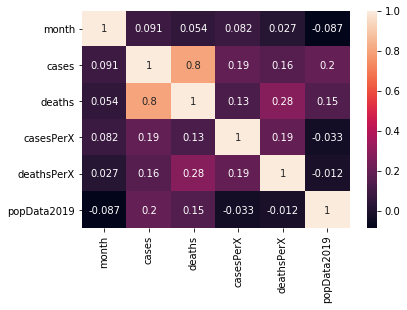

In [22]:
sns.heatmap(df[cols].corr()[cols],annot=True);

In [23]:
#Convert Month to legible format. We have one record for Dec31st - So plot Dec first
df['month'] = df['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                               7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})


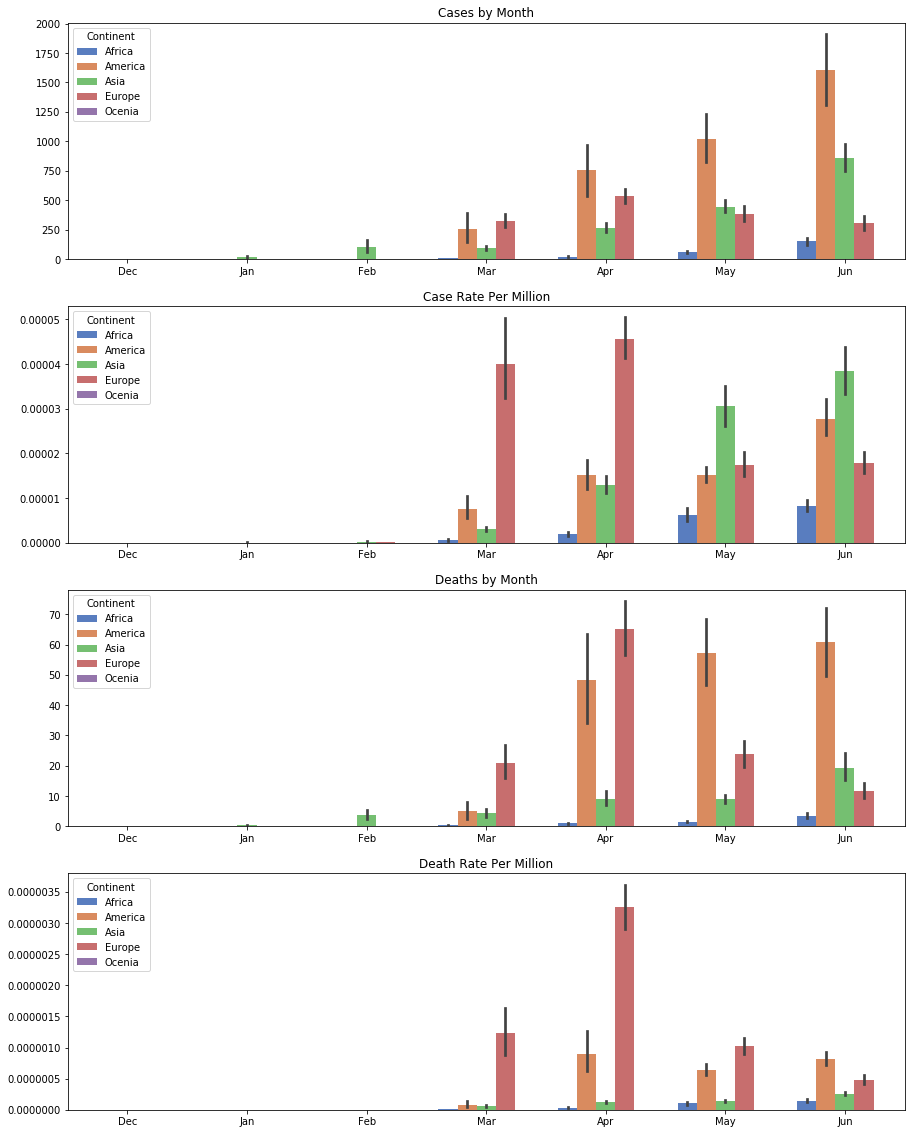

In [24]:
hue_order = ['Africa', 'America','Asia','Europe','Ocenia']
order = list(reversed(df['month'].unique()))
plt.figure(figsize=(15,20))
def plt_barchart(pos,title,yaxis):
    plt.subplot(4,1,pos)
    p1 = sns.barplot(x='month', y=yaxis, data=df, hue='continentExp', palette='muted', order = order, hue_order=hue_order);
    plt.title(title);
    p1.set(xlabel=None)
    p1.set(ylabel=None)
    p1.legend(title='Continent',loc='upper left')

plt_barchart(1,'Cases by Month', 'cases')
plt_barchart(2,'Case Rate Per Million', 'casesPerX')
plt_barchart(3,'Deaths by Month', 'deaths')
plt_barchart(4, 'Death Rate Per Million', 'deathsPerX')



In [25]:
#Perform some queries based on above analysis. Check the total number of cases for the month of June.

df[df['month']=='Jun']['continentExp'].value_counts()


Africa     1540
Europe     1511
America    1371
Asia       1204
Oceania     224
Name: continentExp, dtype: int64

In [26]:
df[df['continentExp']=='America']['countriesAndTerritories'].value_counts()

Canada                               181
United_States_of_America             181
Brazil                               181
Ecuador                              176
Mexico                               173
Dominican_Republic                   172
Chile                                116
Argentina                            114
Peru                                 113
Costa_Rica                           113
Panama                               111
Colombia                             110
Paraguay                             109
Bolivia                              108
Trinidad_and_Tobago                  108
Jamaica                              108
Honduras                             107
Saint_Lucia                          106
Uruguay                              106
Cuba                                 106
Guatemala                            106
Guyana                               106
Venezuela                            105
Barbados                             103
Bahamas         

C:\Users\ldesira\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


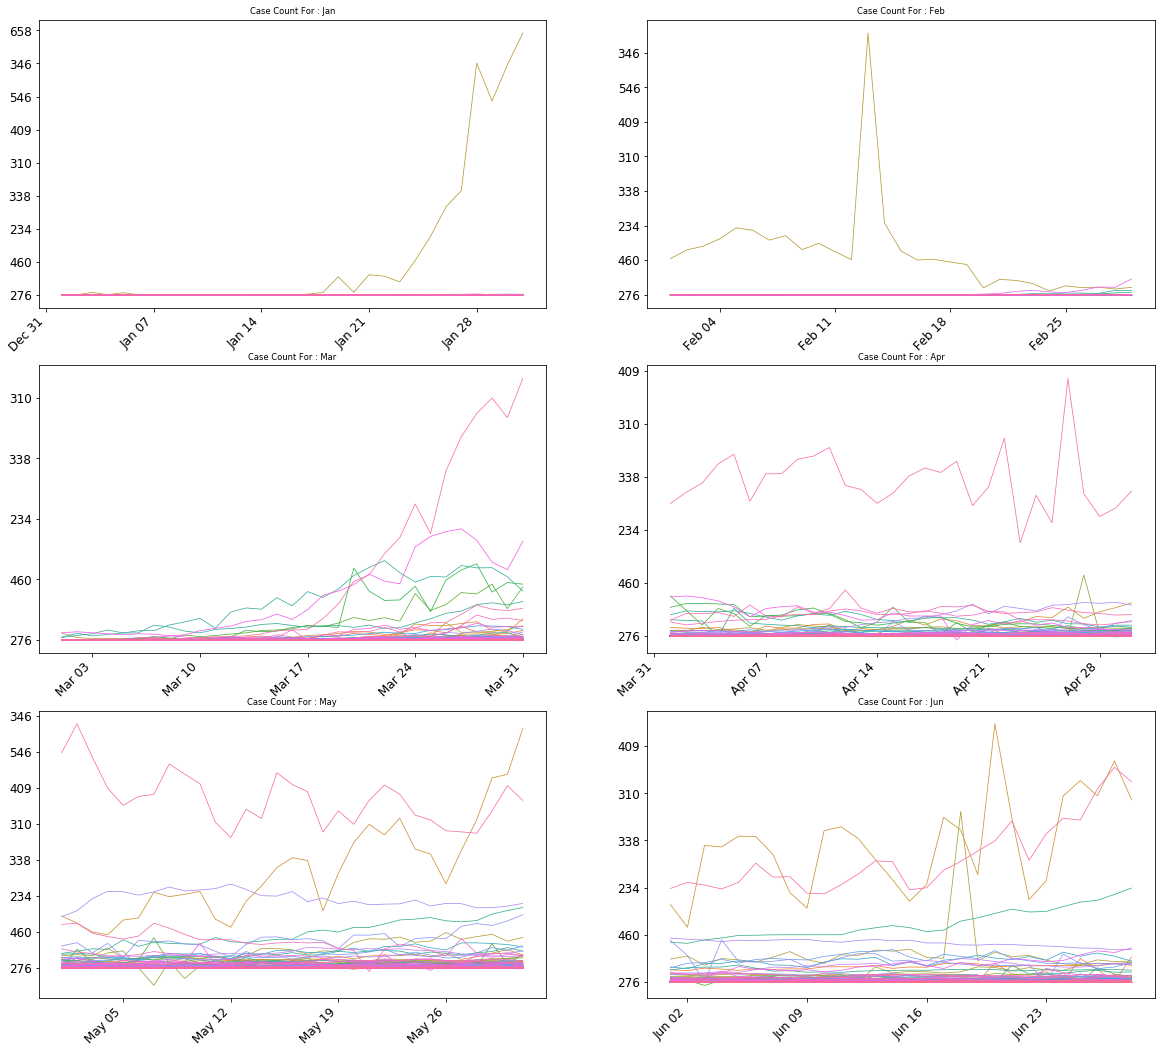

In [27]:
import matplotlib.dates as mdates
df_america = df[df['continentExp'] == 'America']
months_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

fig = plt.figure(figsize=(20,18))
lv_index = 0
def plt_relplot(import_df,title,pos,col): 
    ax1 = fig.add_subplot(3,2,pos)
    p1 = sns.lineplot('dateRep',col, data=import_df, estimator=sum, ci=None, size=5,\
                  hue='countriesAndTerritories',legend=False,ax=ax1);
    p1.set_xticklabels(rotation=45, horizontalalignment='right',
        fontweight='light',
        fontsize=12, labels=df['dateRep']);
    p1.set_yticklabels(horizontalalignment='right',
        fontweight='light',
        fontsize=12,labels=df[col]);
    p1.set_title(title,fontsize='small');
    p1.set_xlabel(xlabel='');
    p1.set_ylabel(ylabel='');
    #set ticks every week
    ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    

for month in months_list:
    df_list = df[df['month'] == month]
    lv_index = lv_index + 1
    title = 'Case Count For : ' + month
    plt_relplot(df_list,title,lv_index,'cases')


**Feature Scaling** 
<p>Implementing the feature scaling on Population Data</p>

In [28]:
#MinMaxScalar ( Normalization )
minmax_scaling = MinMaxScaler()
df['popData2019MinMax'] =  minmax_scaling.fit_transform(df[['popData2019']])
df['casesPerXMinMax'] =  minmax_scaling.fit_transform(df[['casesPerX']])
df['deathsPerXMinMax'] = minmax_scaling.fit_transform(df[['deathsPerX']])

In [29]:
#Standardization ( Z-Score Normalization)
standard_scaler = StandardScaler()

df['popData201Standard'] =  standard_scaler.fit_transform(df[['popData2019']])
df['casesPerXStandard'] =  standard_scaler.fit_transform(df[['casesPerX']])
df['deathsPerXStandard'] = standard_scaler.fit_transform(df[['deathsPerX']])

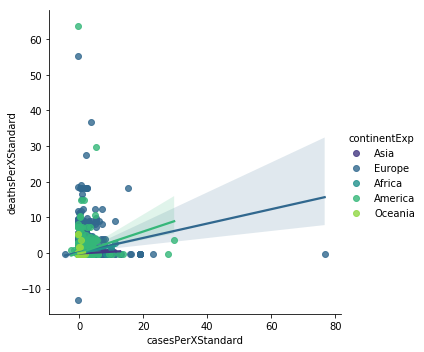

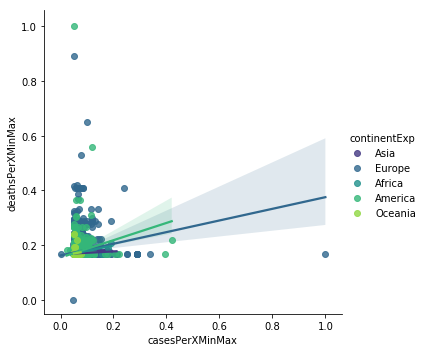

In [30]:
#Standardize cases and death rater per million 


sns.lmplot(y='deathsPerXStandard', x='casesPerXStandard', data=df, hue='continentExp', palette='viridis')

sns.lmplot(y='deathsPerXMinMax', x='casesPerXMinMax', data=df, palette='viridis', hue='continentExp');

In [31]:
#Select which country/territory is most effected in America

df_america = df[df['continentExp'] == 'America']

df_sort = df_america.sort_values(['deathsPerX', 'casesPerX'])
df_sort.tail(5)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,popData2019,continentExp,location,casesPerX,deathsPerX,popData2019MinMax,casesPerXMinMax,deathsPerXMinMax,popData201Standard,casesPerXStandard,deathsPerXStandard
5073,2020-06-08,8,Jun,2020,6405,649,Chile,18952035.0,America,CHL_Chile_CL,0.000338,0.000034,0.013218,0.115914,0.311360,-0.167059,5.054350,10.735585
21788,2020-04-06,6,Apr,2020,2,2,Sint_Maarten,42389.0,America,SXM_Sint_Maarten_SX,0.000047,0.000047,0.000029,0.059663,0.364994,-0.279796,0.497018,14.855890
21771,2020-04-23,23,Apr,2020,5,2,Sint_Maarten,42389.0,America,SXM_Sint_Maarten_SX,0.000118,0.000047,0.000029,0.073354,0.364994,-0.279796,1.606242,14.855890
21786,2020-04-08,8,Apr,2020,15,4,Sint_Maarten,42389.0,America,SXM_Sint_Maarten_SX,0.000354,0.000094,0.000029,0.118991,0.560589,-0.279796,5.303659,29.882077
16506,2020-04-26,26,Apr,2020,0,1,Montserrat,4991.0,America,MSF_Montserrat_MS,0.000000,0.000200,0.000003,0.050535,1.000000,-0.280019,-0.242466,63.639064
